<a href="https://colab.research.google.com/github/kvzl/ML100-Days/blob/master/midterm/Day_101_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機器學習百日馬拉松 期末考

## 取得資料

### 連接雲端硬碟

用來取得放在雲端硬碟的 Kaggle 憑證

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### 從 Kaggle 下載、解壓縮資料

In [0]:
!rm -rf ~/.kaggle && mkdir ~/.kaggle && cp ./gdrive/My\ Drive/個人/keys/kaggle.json ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json && kaggle competitions download -c ml100marathon-final-exam && unzip image_data.zip
!mkdir weights

### 引入所需函式庫

In [0]:
import math
import os
import glob

import numpy as np
from sklearn.model_selection import train_test_split

from PIL import Image
import imgaug as ia
from imgaug  import augmenters as iaa

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 常數

In [0]:
flower_map = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

num_classes = 5

## 輔助函式

### 畫出訓練過程

In [0]:
def plot_train_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    ax[0].plot(loss, label='train')
    ax[0].plot(val_loss, label='test')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(acc, label='train')
    ax[1].plot(val_acc, label='test')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

### 排列顯示圖片

In [0]:
def show_images(images, labels=None, size=(5, 4), start=0):
    row, col = size
    plt.figure(figsize=(10, 6))
    for i in range(row):
        for j in range(col):
            idx = (col * i) + j
            plt.subplot(col, row, idx + 1)
            plt.imshow(images[start + idx])
            if labels is not None:
                plt.title(flower_map[np.argmax(labels[start + idx])])
            plt.axis('off')
    plt.show()

### 將圖片轉為陣列

In [0]:
def image_to_array(filename):
    return np.asarray(Image.open(filename, 'r'))

### 資料處理

In [0]:
def normalize(x):
    x = np.array(x).astype('float32') / 255
    return x


def resize(images, size=(300, 300)):
    width, height = size
    
    seq = iaa.Sequential([
        iaa.PadToFixedSize(width, height),
        iaa.CropToFixedSize(width, height)
    ])
    
    return seq.augment_images(images)


def data_augment(x, y):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Crop(percent=(0, 0.1)),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True)

    x_aug = seq.augment_images(x)
    x += x_aug
    y += y
    
    return x, y

def data_augment_idg(x):
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    datagen.fit(x)
    
    return datagen


def preprocess(images, labels, image_size, data_augmentation='idg'):
    def transform(x, y):
        x = resize(x, size=image_size)
        x = normalize(x)
        y = to_categorical(np.array(y))
        
        return x, y

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)

    x_train, y_train = transform(x_train, y_train)

    if data_augmentation == 'ia':
        x_train, y_train = data_augment(x_train, y_train)
        datagen = None

    elif data_augmentation == 'idg':
        datagen = data_augment_idg(x_train)
   
    x_test, y_test = transform(x_test, y_test)
    
    return (x_train, y_train), (x_test, y_test), datagen

### 讀取訓練資料

In [0]:
def load_data():
    images, labels = [], []
    
    for idx, flower in flower_map.items():
        name = os.path.basename(flower)
        path = 'train/%s/*' % name
        
        for filename in glob.iglob(path):
            images.append(image_to_array(filename))
            labels.append(idx)

    return images, labels

### 讀取所有測試編號

In [0]:
def load_test_ids():
    return np.array([os.path.basename(id).split('.')[0] for id in glob.iglob('test/*.jpg')])

### 讀取測試資料

In [0]:
def load_test_data(ids, image_size, batch_size=10):
    for batch_ids in np.split(ids, len(ids) / batch_size):
        x = [image_to_array('test/%s.jpg' % id) for id in batch_ids]        
        x = resize(x, size=image_size)        
        x = normalize(x)
        
        yield x

### 評估模型

In [0]:
def evaluate(image_size, batch_size=5):
    ids = np.array([os.path.basename(id).split('.')[0] for id in glob.iglob('test/*.jpg')])
    gen = load_test_data(ids, image_size, batch_size)

    return model.predict_generator(gen, 
                         steps=math.ceil(len(ids) / batch_size))

### 取得 Callbacks

In [0]:
def get_callbacks(name='', es=True, es_patience=5):
    file_name = './weights/weights.%s-{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5' % name
        
    red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)
    
    model_cp = ModelCheckpoint(file_name,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               period=3)
    
    callbacks = [red_lr, model_cp]
    
    if es:
        es = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=es_patience,
                           verbose=1, mode='auto', baseline=None, restore_best_weights=True)
        callbacks.append(es)
    
    return callbacks

### 將資料轉成提交用的格式

In [0]:
def to_submit(x, y):
    header = np.array([['id', 'flower_class']])
    arr = np.transpose(np.array([x, y.astype('<U32')]))
    return np.insert(arr, 0, ['id', 'flower_class']).reshape(2001, 2)

### 將儲存的權重複製到雲端硬碟

In [0]:
!cp weights/weights.*.hdf5 gdrive/My\ Drive/Models/

### 將儲存在雲端硬碟的權重複製到本地

In [0]:
!cp gdrive/My\ Drive/Models/weights.*.hdf5 weights/

### 讀取指定 model

In [0]:
def recover_model(name):
    model = tf.keras.models.load_model('weights/%s.hdf5' % name)
    return model

## 訓練模型

### 自訂模型

In [0]:
images, labels = load_data()
(x_train, y_train), (x_test, y_test), datagen = preprocess(images, labels, image_size=(224, 224), data_augmentation='idg')

print((x_train.shape), (y_train.shape))
print((x_test.shape), (y_test.shape))

In [0]:
show_images(x_train, y_train)

In [0]:
def build_custom_cnn():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5,5), padding='Same', activation='relu', input_shape=x_train.shape[1:]),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(64, (3,3), padding='Same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

        layers.Conv2D(96, (3,3), padding='Same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

        layers.Conv2D(96, (3,3), padding='Same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

        layers.Flatten(),
        layers.Dense(512),
        layers.Activation('relu'),
        layers.Dense(5, activation='softmax'),
    ])

    return model

In [23]:
build_custom_cnn().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv

In [0]:
custom_cnn = build_custom_cnn()
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
custom_cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [29]:
batch_size = 128

history = custom_cnn.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=get_callbacks('custom_cnn', es=False)
)

Epoch 1/50
16/16 [==============================] - 25s 2s/step - loss: 0.7522 - acc: 0.7110 - val_loss: 0.8262 - val_acc: 0.6800
Epoch 2/50
16/16 [==============================] - 24s 1s/step - loss: 0.7533 - acc: 0.7136 - val_loss: 0.8286 - val_acc: 0.6800
Epoch 3/50
847/847 [==============================] - 1s 1ms/sample - loss: 0.8361 - acc: 0.6800

Epoch 00003: val_loss improved from inf to 0.82885, saving model to ./weights/weights.custom_cnn-03-0.74-0.83.hdf5
16/16 [==============================] - 24s 1s/step - loss: 0.7483 - acc: 0.7126 - val_loss: 0.8288 - val_acc: 0.6800
Epoch 4/50
16/16 [==============================] - 24s 2s/step - loss: 0.7433 - acc: 0.7115 - val_loss: 0.8299 - val_acc: 0.6812
Epoch 5/50
16/16 [==============================] - 24s 2s/step - loss: 0.7474 - acc: 0.7090 - val_loss: 0.8301 - val_acc: 0.6824
Epoch 6/50
847/847 [==============================] - 1s 1ms/sample - loss: 0.8362 - acc: 0.6836

Epoch 00006: val_loss improved from 0.82885 to 0.8

KeyboardInterrupt: ignored

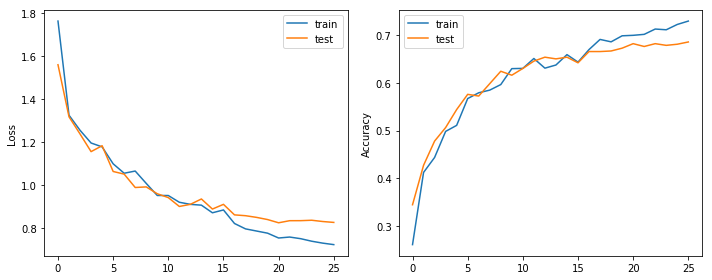

In [26]:
plot_train_history(history)

In [26]:
custom_cnn.evaluate(x_test, y_test)

1694/1694 [==============================] - 3s 2ms/sample - loss: 1.0719 - acc: 0.5962


[1.0719019966958687, 0.596222]

### 使用 MobileNet

In [14]:
images, labels = load_data()
(x_train, y_train), (x_test, y_test), datagen = preprocess(images, labels, image_size=(224, 224))

print((x_train.shape), (y_train.shape))
print((x_test.shape), (y_test.shape))

(1976, 224, 224, 3) (1976, 5)
(847, 224, 224, 3) (847, 5)


In [0]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

def build_mobilenet():
    input = layers.Input(x_train.shape[1:])
    base_model = MobileNetV2(input_tensor=input, weights='imagenet', include_top=True)
    
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(num_classes, activation='softmax')
    ])
    
    for layer in model.layers[:249]:
        layer.trainable = True
    
    return model

In [16]:
build_mobilenet().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1000)              3538984   
_________________________________________________________________
dense (Dense)                (None, 5)                 5005      
Total params: 3,543,989
Trainable params: 3,509,877
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
mobilenet = build_mobilenet()
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
mobilenet.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [18]:
batch_size = 64

history = mobilenet.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=get_callbacks('mobilenet')
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
31/31 [==============================] - 42s 1s/step - loss: 1.5532 - acc: 0.6058 - val_loss: 1.5860 - val_acc: 0.3176
Epoch 2/50
31/31 [==============================] - 30s 982ms/step - loss: 1.5105 - acc: 0.6579 - val_loss: 1.5597 - val_acc: 0.3530
Epoch 3/50
847/847 [==============================] - 3s 3ms/sample - loss: 1.5625 - acc: 0.3070

Epoch 00003: val_loss improved from inf to 1.55940, saving model to ./weights/weights.mobilenet-03-1.48-1.56.hdf5
31/31 [==============================] - 37s 1s/step - loss: 1.4805 - acc: 0.6058 - val_loss: 1.5594 - val_acc: 0.3070
Epoch 4/50
31/31 [==============================] - 30s 955ms/step - loss: 1.4585 - acc: 0.5673 - val_loss: 1.5973 - val_acc: 0.2586
Epoch 5/50
847/847 [==============================] - 2s 3ms/sample - loss: 1.5416 - acc: 0.3447

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
31/31 [==============================] - 34s 1

In [0]:
plot_train_history(history)

### 使用 Xception

In [21]:
images, labels = load_data()
(x_train, y_train), (x_test, y_test), datagen = preprocess(images, labels, image_size=(299, 299), data_augmentation='idg')

print((x_train.shape), (y_train.shape))
print((x_test.shape), (y_test.shape))

(1976, 299, 299, 3) (1976, 5)
(847, 299, 299, 3) (847, 5)


In [0]:
from tensorflow.keras.applications.xception import Xception


def build_xception():
    input = layers.Input(x_train.shape[1:])
    base_model = Xception(include_top=True, input_tensor=input, weights='imagenet')
    
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(num_classes, activation='softmax')
    ])
    
    for layer in model.layers[:249]:
        layer.trainable = True
    
    return model

In [23]:
build_xception().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 1000)              22910480  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5005      
Total params: 22,915,485
Trainable params: 22,860,957
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
xception = build_xception()
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
xception.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [30]:
batch_size = 16

history = xception.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=get_callbacks('xception')
)

Epoch 1/50
124/124 [==============================] - 195s 2s/step - loss: 1.5380 - acc: 0.6037 - val_loss: 1.5972 - val_acc: 0.2739
Epoch 2/50
124/124 [==============================] - 187s 2s/step - loss: 1.4760 - acc: 0.5374 - val_loss: 1.5691 - val_acc: 0.2916
Epoch 3/50
 39/124 [========>.....................] - ETA: 1:54 - loss: 1.4127 - acc: 0.6218

KeyboardInterrupt: ignored

In [0]:
plot_train_history(history)

## 提交

In [39]:
recover_model('weights.mobilenet-30-1.31-1.39').evaluate(x_test, y_test)

847/847 [==============================] - 4s 5ms/sample - loss: 1.3646 - acc: 0.8076


[1.3646023290357172, 0.8075561]

In [0]:
ids = load_test_ids()
model = recover_model('weights.mobilenet-30-1.31-1.39')
# model = custom_cnn
result = evaluate(ids, image_size=(224, 224))

In [0]:
pred = np.argmax(result, axis=1)

In [0]:
submission = to_submit(ids, pred)

In [0]:
np.savetxt('submission.csv', submission, delimiter=',', fmt='%s')